In [1]:
from sksurv import datasets
import numpy as np
from sksurv.preprocessing import OneHotEncoder
from icare.metrics import harrell_cindex, harrell_cindex_scorer
from icare.survival import IcareSurv, BaggedIcareSurv


X, y = datasets.load_veterans_lung_cancer()
X = OneHotEncoder().fit_transform(X)

model = IcareSurv()
model.fit(X, y)
pred = model.predict(X)
print(pred[:5])
harrell_cindex(y, pred)

[-0.0716535  -0.57249692 -0.0716535  -0.0716535  -0.57249692]


0.7092798727850976

In [2]:
from sklearn.model_selection import cross_val_score, ShuffleSplit

model = IcareSurv()
score = cross_val_score(model, X, y,
                        cv=ShuffleSplit(n_splits=4, test_size=.25, random_state=42),
                        n_jobs=4,
                        scoring=harrell_cindex_scorer).mean()
score

0.6947391484658725

If you have to array for the time and the event:

In [3]:
X, y = datasets.load_veterans_lung_cancer()
X = OneHotEncoder().fit_transform(X)

time = [x[1] for x in y]
event = [x[0] for x in y]

time[:10], event[:10]

([72.0, 411.0, 228.0, 126.0, 118.0, 10.0, 82.0, 110.0, 314.0, 100.0],
 [True, True, True, True, True, True, True, True, True, False])

If you give the time without the censoring, the model will assume that there is no censoring in the dataset

In [4]:
model = IcareSurv()
cross_val_score(model, X, time,
                cv=ShuffleSplit(n_splits=4, test_size=.25, random_state=42),
                n_jobs=4,
                scoring=harrell_cindex_scorer).mean()

0.5

You have to merge them into one array like this:

In [5]:
from sksurv.util import Surv
y = Surv.from_arrays(event=np.array(event).astype('bool'), time=time)
y[:10]

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.)],
      dtype=[('event', '?'), ('time', '<f8')])

In [6]:
model = IcareSurv()
cross_val_score(model, X, y,
                cv=ShuffleSplit(n_splits=4, test_size=.25, random_state=42),
                n_jobs=4,
                scoring=harrell_cindex_scorer).mean()

0.6947391484658725

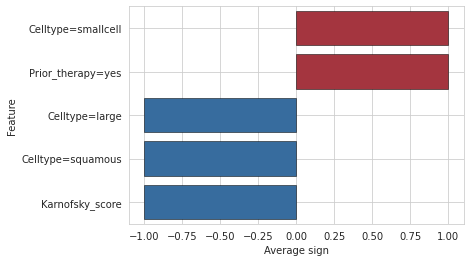

In [15]:
from icare.visualiation import plot_avg_sign

X, y = datasets.load_veterans_lung_cancer()
X = OneHotEncoder().fit_transform(X)
model = BaggedIcareSurv(n_estimators=10, n_jobs=-1)
model.fit(X,y)
plot_avg_sign(model)

In [ ]:
from icare.visualiation import plot_avg_sign

X, y = datasets.load_aids()
X = OneHotEncoder().fit_transform(X)
model = BaggedIcareSurv(n_estimators=10, n_jobs=-1)
model.fit(X,y)
plot_avg_sign(model)